# Final figures

That is, numbers and plots for the paper, and making one big dataframe for rummaging around in. Notebook hopefully straightforward - listing parsed data objects, reading them in and converting the dictionaries to a nice dataframe
- top level column index is model + prompt configuration / true
- second level:
-- `a` is for the left fact of quadruple {thing_a} and {element_a} 
-- `b` is for the right fact of quadruple {thing_b} and {element_b}
-- `a_is_num` and `b_is_num` flags when the facts are numbers and thus can have Entailment evaluated
-- `rel` is the relationship string returned by LLM
-- finally `rel_ent` is the _entailed_ relationship between facts `a` and `b`
- indexing by the quadruples, unfortunately slightly counter-intuitive (thing_a, thing_b, elements_a, elements_b), I think it was natural from data construction point of view to make sure subject pairs do not repeat or sth



In [1]:
# re-loads code before cell execution, so if sth changes it will propagate:
%load_ext autoreload
%autoreload 2

In [34]:
import os, sys
import logging

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append('..')

import ear.utilities as tut
from ear.entail import NumericalEntailmentBase
from ear.evaluate import *

### Set up logging

Specify logger(s), level(s) and where to log to, like so:

In [3]:
logger = logging.getLogger('ear')
tut.configure_loggers( 
    [logger], logging.DEBUG, log_here= True
)

logger.debug('K, it worked')

2024-06-29 19:21:03 | DEBUG @ ear
                    | K, it worked


## Set up namespace, e.g. point to data

In [61]:
folder = '../data/entailment/'
to_eval = [f'{folder}/{x}' for x in os.listdir(folder) if '_parsed' in x]

In [36]:
def get_accuracies( dfe, model):
    dict_ = {}
    dict_accuracies = {}
    for item in ['a','b','rel']:
        dict_[ item] = (dfe[ model][ item] == dfe[ 'true'][ item])
        dict_accuracies[ item] = [dict_[ item].sum().sum() / len( dfe)]        
    dict_accuracies[ 'a_b'] = [( dict_['a'] & dict_['b']).sum().sum() / len(dfe)]
    dict_accuracies[ 'gold'] = [( dict_['a'] & dict_['b'] & dict_['rel']).sum().sum() / len(dfe)]
    dict_accuracies[ 'ent'] = [(dfe[ model]['rel'] == dfe[ model]['rel_ent']).sum().sum() / len(dfe)]
    return dict_accuracies

In [37]:
colors = ['lightsteelblue','thistle','gold','steelblue','darkslateblue','goldenrod']

def plot_bar_set( data_dict, tooth_gap_after, width, ax, colors, legend,  extra_flag= False):
    tooth_gap = 0
    for ii, model in enumerate( data_dict.keys()):
        sub_ = data_dict[ model]
        if ii >= tooth_gap_after:
            tooth_gap = 0.05
        xes = [x + width*ii + tooth_gap for x in range(len(sub_))]
        if extra_flag:
            ax.bar( xes, sub_.values, width= width, color= colors[ii], label= legend[ii])
        else:
            ax.bar( xes, sub_.values, width= width, color= colors[ii], label= legend[ii], edgecolor='black', alpha=0.3)
    return tooth_gap, sub_
        
    
    

def plot_grouped_bars( 
    data_dict, tooth_gap_after = None, wide= False, file_out= None, ylabel= 'Proportion correct', width= 0.13,
    colors= colors, labels= None, rotation= 35, legend= None, xlim= None, extra_dict= None
):
    tooth_gap_after = tooth_gap_after if tooth_gap_after is not None else len(data_dict)
    legend = legend if legend is not None else list(data_dict.keys())
    if wide:
        _, ax = plt.subplots( figsize= (16,5))
    else:
        _, ax = plt.subplots( figsize= (13,4))
    
    flag_ = False
    if extra_dict is None:
        flag_ = True
    tooth_gap, sub_ = plot_bar_set( data_dict, tooth_gap_after, width, ax, colors, legend, flag_)    
    if extra_dict is not None:
        plot_bar_set( 
            extra_dict, tooth_gap_after, width, ax, colors, [x for x in legend[len(data_dict):]], True
        )
    
    _ = ax.set_xticks( [x  + (ii*width + tooth_gap)/2 for x in range(len(sub_))])
    #_ = ax.set_xticks( [x -1/2 + (ii*width + tooth_gap)/2 for x in range(len(sub_))])
    if labels is not None:
        _ = ax.set_xticklabels( labels, rotation= rotation, fontsize= 12)
    ax.set_ylabel( ylabel, fontsize= 13)
    
    if wide:
        plt.legend(fontsize=13)
    else:
        plt.legend(bbox_to_anchor= (1.01, 0.5), loc= 'center left', fontsize= 13)
    if xlim:
        ax.set_xlim( xlim)
    if file_out is not None:
        plt.savefig( file_out, dpi=400, bbox_inches= 'tight')

In [38]:
def make_suffix( file_):
    part1 = file_.split('fact-')[1].split('_')[0].replace('v','f')
    part2 = file_.split('shot-')[0].split('-')[-1]
    part3 = ''
    if '_qa_' in file_:
        part3 = 'q'
    return f'{part1}s{part2}{part3}'

## Investigate data, try things out 

_**you can even add fancy markdown throughout to document things..?**_

In [40]:
dfs = None
dfe = None
drop_element = 'annenae'
for ii, file_ in enumerate(to_eval):
    NEP_ = NumericalEntailmentBase.load( file_)
    split_on = '/'
    print(f'Load {file_.split(split_on)[-1]}.')
    NEP_.model = NEP_.model.replace('Mistral','mist').replace('-Instruct','i').replace('-v0.','')
    suffix_ = make_suffix( file_)    
    if dfs is None:
        dfs_ = make_frame_subjects( NEP_, suffix= suffix_, ground_truth= True)
        dfe_ = make_frame_entailed( NEP_, suffix= suffix_, ground_truth= True)
        drop_ids = [x for x in dfe_.index if drop_element in x]
        drop_ix = [x for x in dfs_.index if drop_element == x]
        dfs = dfs_.drop(labels= drop_ix, axis=0)
        dfe = dfe_.drop(labels= drop_ids, axis= 0)
    else:
        dfs_ = make_frame_subjects( NEP_, suffix= suffix_)
        dfe_ = make_frame_entailed( NEP_, suffix= suffix_)
        drop_ids = [x for x in dfe_.index if drop_element in x]
        drop_ix = [x for x in dfs_.index if drop_element == x]
        dfs = dfs.merge( dfs_.drop(labels= drop_ix, axis=0), left_index= True, right_index= True)
        dfe = dfe.merge( dfe_.drop(labels= drop_ids, axis= 0), left_index= True, right_index= True)

models_ = sorted([x for x in dfe.columns.get_level_values('model').unique() if x != 'true'])

Load synth_subjects_00_fact-v0_prompt-0shot-v0_gpt-3.5-turbo_parsed.pickle.
Load synth_subjects_00_fact-v0_prompt-0shot-v0_gpt-4_parsed.pickle.
Load synth_subjects_00_fact-v1_prompt-0shot-v1_gpt-3.5-turbo_parsed.pickle.
Load synth_subjects_00_fact-v1_prompt-0shot-v1_gpt-4_parsed.pickle.
Load synth_subjects_00_fact-v1_prompt-1shot-v1_gpt-3.5-turbo_parsed.pickle.
Load synth_subjects_00_fact-v1_prompt-1shot-v1_gpt-4_parsed.pickle.
Load synth_subjects_00_mask_fact-v0_prompt-0shot-v0_Mistral-7B-Instruct-v0.1_parsed.pickle.
Load synth_subjects_00_mask_fact-v0_prompt-0shot-v0_Mistral-7B-Instruct-v0.2_parsed.pickle.
Load synth_subjects_00_mask_fact-v1_prompt-0shot-v1_Mistral-7B-Instruct-v0.1_parsed.pickle.
Load synth_subjects_00_mask_fact-v1_prompt-0shot-v1_Mistral-7B-Instruct-v0.2_parsed.pickle.
Load synth_subjects_00_mask_fact-v1_prompt-1shot-v1_Mistral-7B-Instruct-v0.1_parsed.pickle.
Load synth_subjects_00_mask_fact-v1_prompt-1shot-v1_Mistral-7B-Instruct-v0.2_parsed.pickle.
Load synth_subje

In [41]:
labels_ = [
    x_.replace('-','').replace('mist','mi').replace('f0s0',' 0-shot A').replace('f1s0',' 0-shot B').replace('f1s1',' 1-shot B') 
    for x_ in models_
]

In [42]:
dfe[['true','mist-7Bi1-f1s0']].head(2)

model                           true          mist-7Bi1-f1s0           \
answer                             a  b   rel              a  b   rel   
probe                                                                   
(bicycle, car, chains, chains)     1  0  more              2  4  more   
(bicycle, car, chains, engines)    1  1  same              2  4  more   

model                                                      
answer                          a_is_num b_is_num rel_ent  
probe                                                      
(bicycle, car, chains, chains)      True     True    less  
(bicycle, car, chains, engines)     True     True    less

In [43]:
dfe.loc[ 
    same_ans_for_models( dfe, 'mist-7Bi1-f0s0', 'mist-7Bi1-f1s0') 
    & same_ans_for_models( dfe, 'mist-7Bi1-f1s0', 'mist-7Bi1-f1s1')
    & same_ent( dfe, 'mist-7Bi1-f1s0')
].shape

(240, 87)

In [44]:
dfe.loc[ 
    same_ans_for_models( dfe, 'gpt-4-f0s0', 'gpt-4-f1s0') 
    & same_ans_for_models( dfe, 'gpt-4-f1s0', 'gpt-4-f1s1')
    & same_ent( dfe, 'gpt-4-f1s0')
].shape

(1083, 87)

In [11]:
dfe.loc[~(dfe['mist-7Bi1-f0s0']['a_is_num']),['mist-7Bi1-f0s0']]

Empty DataFrame
Columns: [(mist-7Bi1-f0s0, a), (mist-7Bi1-f0s0, b), (mist-7Bi1-f0s0, rel), (mist-7Bi1-f0s0, a_is_num), (mist-7Bi1-f0s0, b_is_num), (mist-7Bi1-f0s0, rel_ent)]
Index: []

In [207]:
(dfs['gpt-3.5-f0s0'] == dfs['gpt-4-f0s0']).sum().sum() / 279

0.4838709677419355

In [45]:
for model in models_:
    print(model,dfe[ model][ 'rel'].unique())

gpt-3.5-f0s0 ['less' 'less|more' 'more']
gpt-3.5-f1s0 ['less' 'more|same' 'less|more' 'more' 'same']
gpt-3.5-f1s1 ['less' 'same' 'more']
gpt-4-f0s0 ['less' 'more']
gpt-4-f1s0 ['less' 'more' 'same']
gpt-4-f1s1 ['more' 'same' 'less' 'similar']
mist-7Bi1-f0s0 ['more']
mist-7Bi1-f1s0 ['more' 'less']
mist-7Bi1-f1s0q ['less' 'less|more|same' 'less|more' 'same' 'more|same' '' 'more']
mist-7Bi1-f1s1 ['less' 'less|more' 'more' '' 'same' 'less|same' 'more|same']
mist-7Bi2-f0s0 ['less' 'more' 'less|more' 'less|more|same' 'less|same']
mist-7Bi2-f1s0 ['less' 'less|more' 'more' 'less|same' 'less|more|same' 'usually'
 'more|same' 'three']
mist-7Bi2-f1s0q ['less' 'less|more' 'less|same']
mist-7Bi2-f1s1 ['less' '' 'same' 'less|same' 'more' 'less|more' 'more|same'
 'less|more|same' 'not']


In [109]:
(dfe['true']['a'] == 0).sum() / len(dfe), (dfe['true']['b'] == 0).sum() / len(dfe)

(0.45910378144261205, 0.45010827919373647)

In [107]:
((dfe['true']['a']==0)&(dfe['true']['b']==0)).sum()/len(dfe)

0.19606863235049143

In [110]:
((dfe['true']['a']==0)&(dfe['true']['b']==0)&(dfe['true']['rel']=='same')).sum()/len(dfe)

0.19606863235049143

In [113]:
(dfe['true']['rel'] == np.random.choice(['less','more'], len(dfe))).sum() / len(dfe)

0.351824087956022

### overal results - entailment

In [46]:
dfo = pd.DataFrame()
for model_, label_ in zip(models_, labels_):
    dfo = pd.concat([ dfo, pd.DataFrame(get_accuracies( dfe, model_), index= [label_])])
dfo_ = dfo.round(3)

In [47]:
dfo_

,a,b,rel,a_b,gold,ent
gpt3.5 0-shot A,0.534,0.495,0.369,0.261,0.105,0.396
gpt3.5 0-shot B,0.612,0.526,0.404,0.318,0.144,0.433
gpt3.5 1-shot B,0.834,0.785,0.461,0.647,0.304,0.453
gpt4 0-shot A,0.843,0.811,0.585,0.680,0.417,0.627
gpt4 0-shot B,0.817,0.812,0.445,0.658,0.308,0.457
gpt4 1-shot B,0.878,0.877,0.557,0.766,0.434,0.555
mi7Bi1 0-shot A,0.386,0.396,0.370,0.140,0.064,0.462
mi7Bi1 0-shot B,0.328,0.303,0.374,0.092,0.040,0.452
mi7Bi1 0-shot Bq,0.557,0.495,0.351,0.274,0.093,0.359
mi7Bi1 1-shot B,0.300,0.252,0.476,0.081,0.037,0.259


In [139]:
#dfe['mist-7Bi-f1s1']['rel'].unique()

In [48]:
for id_ in [x for x in dfo_.index if 'q' not in x]:
    vals = [id_] + dfo_.loc[ id_,['a','b','a_b','rel','gold','ent']].values.tolist()
    #make_str = ' & '.join([str(x) if i!= best else '\\textbf{'+str(x)+'}' for i,x in vals])+'\\\\'
    make_str =' & '.join([str(x) for x in vals]) + '\\\\'
    print(make_str)
    

gpt3.5 0-shot A & 0.534 & 0.495 & 0.261 & 0.369 & 0.105 & 0.396\\
gpt3.5 0-shot B & 0.612 & 0.526 & 0.318 & 0.404 & 0.144 & 0.433\\
gpt3.5 1-shot B & 0.834 & 0.785 & 0.647 & 0.461 & 0.304 & 0.453\\
gpt4 0-shot A & 0.843 & 0.811 & 0.68 & 0.585 & 0.417 & 0.627\\
gpt4 0-shot B & 0.817 & 0.812 & 0.658 & 0.445 & 0.308 & 0.457\\
gpt4 1-shot B & 0.878 & 0.877 & 0.766 & 0.557 & 0.434 & 0.555\\
mi7Bi1 0-shot A & 0.386 & 0.396 & 0.14 & 0.37 & 0.064 & 0.462\\
mi7Bi1 0-shot B & 0.328 & 0.303 & 0.092 & 0.374 & 0.04 & 0.452\\
mi7Bi1 1-shot B & 0.3 & 0.252 & 0.081 & 0.476 & 0.037 & 0.259\\
mi7Bi2 0-shot A & 0.559 & 0.493 & 0.269 & 0.388 & 0.116 & 0.449\\
mi7Bi2 0-shot B & 0.47 & 0.455 & 0.2 & 0.407 & 0.082 & 0.394\\
mi7Bi2 1-shot B & 0.59 & 0.51 & 0.301 & 0.388 & 0.104 & 0.308\\


In [49]:
for id_ in [x for x in dfo_.index if 'q' in x]:
    vals = [id_] + dfo_.loc[ id_,['a','b','a_b','rel','gold','ent']].values.tolist()
    #make_str = ' & '.join([str(x) if i!= best else '\\textbf{'+str(x)+'}' for i,x in vals])+'\\\\'
    make_str =' & '.join([str(x) for x in vals])+ '\\\\'
    print(make_str)

mi7Bi1 0-shot Bq & 0.557 & 0.495 & 0.274 & 0.351 & 0.093 & 0.359\\
mi7Bi2 0-shot Bq & 0.695 & 0.691 & 0.483 & 0.352 & 0.145 & 0.285\\


## Focus on subjects / numbers...

Collect overall accuracies, generate plots etc..

In [53]:
data_dict = {}
for ii, model in enumerate( models_):
    data_dict[ model] = (dfs[ model] == dfs[ 'true']).mean()
    data_dict[ model].loc['overall'] = (dfs[ model] == dfs[ 'true']).sum().sum() / (dfs[ 'true'] == dfs[ 'true']).sum().sum()

gpt_sub_dict = {k:v for k,v in data_dict.items() if 'gpt' in k}
mi_sub_dict = {k:v for k,v in data_dict.items() if 'mi' in k and 'q' not in k}
qa_sub_dict = {k:v for k,v in data_dict.items() if 'q' in k}

In [54]:
mi_sub_dict.keys()

dict_keys(['mist-7Bi1-f0s0', 'mist-7Bi1-f1s0', 'mist-7Bi1-f1s1', 'mist-7Bi2-f0s0', 'mist-7Bi2-f1s0', 'mist-7Bi2-f1s1'])

In [55]:
num_accuracies = (
    [np.round(v['overall'],2) for k, v in gpt_sub_dict.items() if 'gpt-3.5' in k] +
    [np.round(v['overall'],2) for k, v in gpt_sub_dict.items() if 'gpt-4' in k] +
    [np.round(v['overall'],2) for k, v in mi_sub_dict.items() if 'i1' in k] +
    [np.round(v['overall'],2) for k, v in qa_sub_dict.items() if 'i1' in k] +
    [np.round(v['overall'],2) for k, v in mi_sub_dict.items() if 'i2' in k] +
    [np.round(v['overall'],2) for k, v in qa_sub_dict.items() if 'i2' in k]
)

In [56]:
' & '.join([str(x) for x in num_accuracies]) +'\\'

'0.41 & 0.51 & 0.81 & 0.85 & 0.81 & 0.91 & 0.35 & 0.19 & 0.2 & 0.54 & 0.6 & 0.49 & 0.61 & 0.79\\'

In [57]:
pd.Series(dfs['true'].values.reshape(-1)).value_counts()[:2]

0    207
2     25
dtype: int64

In [58]:
for model_ in models_:
    err = (dfs[model_]!=dfs['true']).sum().sum()
    err_on_zero = (
        ((dfs[model_] != dfs['true']) & (dfs['true']==0)).sum().sum() 
    )
    zero_on_err = (
        ((dfs[model_]==0) & (dfs['true']!=0)).sum().sum()
    )
    print( model_, err_on_zero/err, zero_on_err/err)

gpt-3.5-f0s0 0.89375 0.00625
gpt-3.5-f1s0 0.8636363636363636 0.007575757575757576
gpt-3.5-f1s1 0.8 0.02
gpt-4-f0s0 0.7560975609756098 0.04878048780487805
gpt-4-f1s0 0.8235294117647058 0.058823529411764705
gpt-4-f1s1 0.72 0.04
mist-7Bi1-f0s0 0.8285714285714286 0.005714285714285714
mist-7Bi1-f1s0 0.863013698630137 0.0
mist-7Bi1-f1s0q 0.7661290322580645 0.03225806451612903
mist-7Bi1-f1s1 0.8379629629629629 0.004629629629629629
mist-7Bi2-f0s0 0.7155963302752294 0.03669724770642202
mist-7Bi2-f1s0 0.7518248175182481 0.014598540145985401
mist-7Bi2-f1s0q 0.5 0.20689655172413793
mist-7Bi2-f1s1 0.6952380952380952 0.0380952380952381


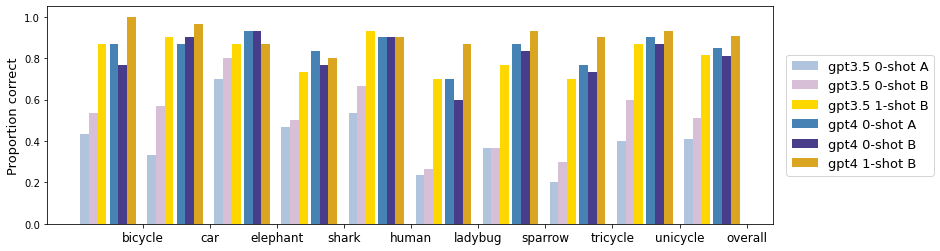

In [59]:
plot_grouped_bars( 
    gpt_sub_dict, tooth_gap_after= 3, #file_out= '../data/figures/performance_numbers_gpt.eps', 
    labels= [x.split()[-1] for x in data_dict['gpt-3.5-f0s0'].index], rotation= 0, legend= [l for l in labels_ if 'q' not in l],
    #extra_dict= mi_sub_dict
)

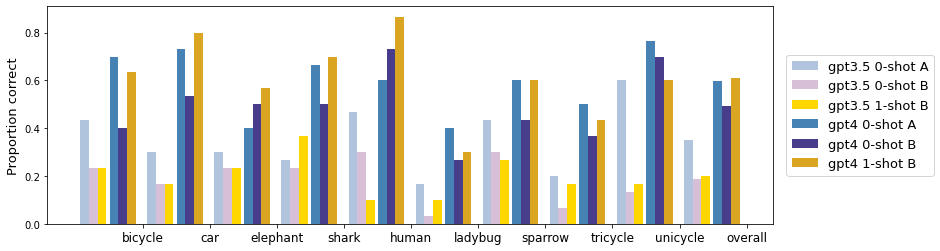

In [60]:
plot_grouped_bars( 
    mi_sub_dict, tooth_gap_after= 3, #file_out= '../data/figures/performance_numbers_mi.eps', 
    labels= [x.split()[-1] for x in data_dict['gpt-3.5-f0s0'].index], rotation= 0, legend= labels_
)

drilling a bit further into the nature of errors (object bias vs elements bias)

In [84]:
elems = dfs['gpt-3.5-f1s0']['unicycle'].index
elems_ = [x for x in elems if x not in ('tyres','wheels')]

In [85]:
data_dict = {}
model = 'gpt-3.5-f1s0'
legend = ['unicycle', 'bicycle', 'tricycle']
for ii, label in enumerate( legend):
    data_dict[ label] = (dfs[ model][ label].loc[elems_])

In [86]:
element_labels = [
    x.replace(' altogether',' all').replace('pairs of ','p.o. ').replace(' leg','').replace(' foot','').replace(' hand','')
    .replace(' on each',' o.e.').replace('dorsal ','d. ').replace('pectoral ','p. ')
    .replace(' pipes','').replace('wing ','w. ').zfill(11).replace('0',' ')
    for x in elems_
]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


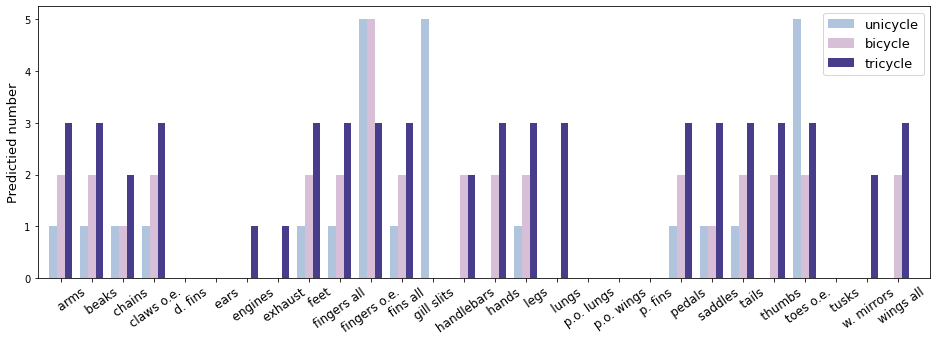

In [87]:
plot_grouped_bars( 
    data_dict, wide= True, width= 0.25, ylabel= 'Predictied number', colors= ['lightsteelblue','thistle','darkslateblue'],
    labels = element_labels, legend= legend, file_out= '../data/figures/subject_bias_gpt.eps', xlim= [-0.5,28.3]
)

### see if Mistral does similarly

In [88]:
data_dict = {}
model = 'mist-7Bi1-f1s0'
legend = ['unicycle', 'bicycle', 'tricycle']
elems = dfs['mist-7Bi2-f1s0']['unicycle'].index
elems_ = [x for x in elems if x not in ('tyres','wheels')]
for ii, label in enumerate( legend):
    data_dict[ label] = (dfs[ model][ label].loc[elems_])

In [80]:
element_labels = [
    x.replace(' altogether',' all').replace('pairs of ','p.o. ').replace(' leg','').replace(' foot','').replace(' hand','')
    .replace(' on each',' o.e.').replace('dorsal ','d. ').replace('pectoral ','p. ')
    .replace(' pipes','').replace('wing ','w. ').zfill(11).replace('0',' ')
    for x in elems_
]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


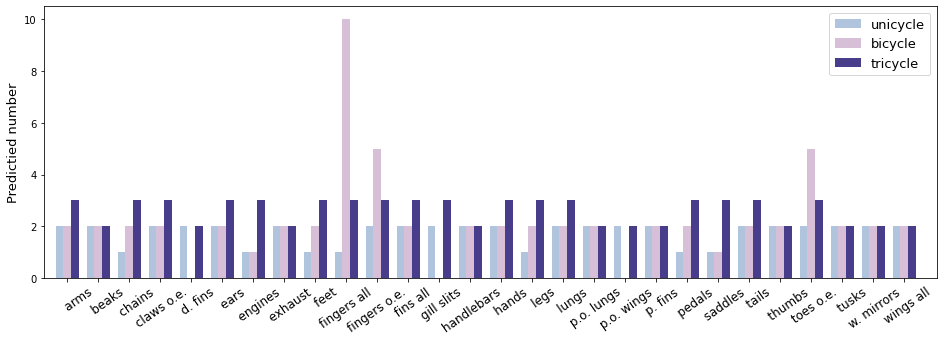

In [89]:
plot_grouped_bars( 
    data_dict, wide= True, width= 0.25, ylabel= 'Predictied number', colors= ['lightsteelblue','thistle','darkslateblue'],
    labels = element_labels, legend= legend, xlim= [-0.5,28.3], 
    file_out= '../data/figures/subject_bias_mi.eps'
)

In [52]:
len(element_labels)

30

In [333]:
subjects=dfs.columns.get_level_values('subject').unique()

In [45]:
data_dict = {}
model = 'gpt-3.5-f0s0'
subjects = dfs.columns.get_level_values('subject').unique()
for ii, label in enumerate( ['fingers on each hand','toes on each foot']):
    data_dict[ label] = dfs[ model][ subjects].loc[ label] #- dfs[ 'true'][ subjects].loc[ label])

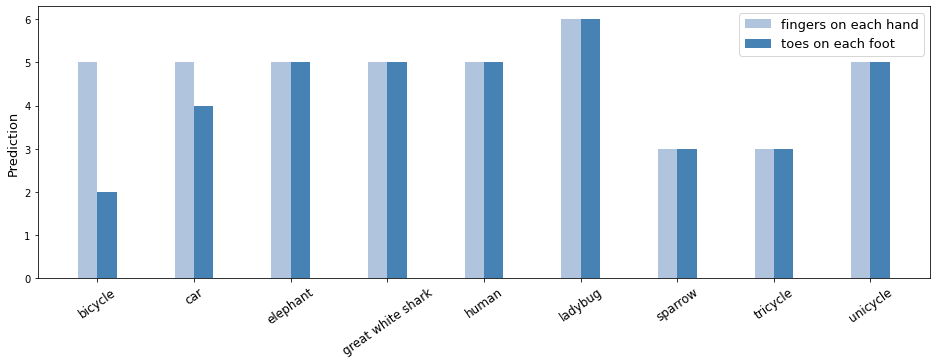

In [46]:
plot_grouped_bars( 
    data_dict, wide= True, width= 0.2, ylabel= 'Prediction', colors= ['lightsteelblue','steelblue'],
    labels = subjects
)